In [1]:
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

In [2]:
arr=jnp.array([1.])
print(arr.devices())
print(arr.dtype)

{cuda(id=0)}
float64


In [3]:
pip install -q git+https://github.com/ott-jax/ott@main



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib

import numpy as np
import time
import timeit
from jax.example_libraries import optimizers as jax_opt


import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1


import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from sklearn.datasets import make_blobs


import warnings
warnings.filterwarnings("ignore")


In [5]:

@jax.jit
def dCdx(x, y):
  # if sqEuclidean
  # each row calculates dC_k/dx_k

  #return 2*(x-y.transpose())
  return 2 * (x[:, None, :] - y[None, :, :]) # M X N X d

@jax.jit
def dOTdx(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  grad = jnp.sum(dCk_dxk * P[:,:,None], axis=1)
  return grad # M X d




@jax.jit
def LHS_matrix(ot): #
  a = ot.a # size of M
  b = ot.b # size of N
  P = ot.matrix # M by N
  a_P = jnp.sum(P, axis=1)
  b_P = jnp.sum(P, axis=0)

  a_diag = jnp.diag(a_P)  # N by N
  b_diag = jnp.diag(b_P)  # M by M
  PT     = jnp.transpose(P)

  H1 = jnp.concatenate([a_diag, P], axis = 1) # M by (M+N)
  H2 = jnp.concatenate([PT, b_diag], axis = 1) # N by (M+N)
  H = jnp.concatenate([H1, H2], axis=0) # (M+N) by (M+N)

  return H




@jax.jit
def d2Cdx2(x, y):
  # if sqEuclidean
  # the second derivative is 2
  return 2


@jax.jit
def RHS(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  b_g = jnp.transpose(dCk_dxk * P[:,:,None], [1,0,2]) # N by M by d

  b_g_col = jnp.sum(b_g, axis=0) # M by D

  M, D = b_g_col.shape
  b_f  = jnp.zeros((M, M, D))
  indices = (jnp.arange(M), jnp.arange(M))
  b_f = b_f.at[indices[0], indices[1], :].set(b_g_col) # M by M by d

  b = jnp.concatenate([b_f, b_g], axis=0) # (M+N) X M X d
  return b

@jax.jit
def Sinkhorn_Hessian(ot,svd_thr=1e-10):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  #R_reshape = jnp.reshape(R, [nm, m*dim])
  #HdagR_reshape = jnp.linalg.lstsq(H, R_reshape, svd_thr)[0]
  #HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  #Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon
  
  eigenvalues, eigenvectors = jnp.linalg.eigh(H)
  eigenvalues_sqrt_inv = jnp.where(eigenvalues>svd_thr, 1/jnp.sqrt(eigenvalues), 0)
  Hsqrt = eigenvectors * eigenvalues_sqrt_inv[jnp.newaxis, :] # (M+N) by r


  bHsqrt  = jnp.einsum('ikd, is ->ksd ', R, Hsqrt)  #
  Hessian_1 = jnp.einsum('ksd, jst->kdjt', bHsqrt, bHsqrt)/epsilon



  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian


@jax.jit
def Sinkhorn_Hessian_no_reg(ot):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  R_reshape = jnp.reshape(R, [nm, m*dim])
  HdagR_reshape = jnp.linalg.solve(H, R_reshape)
  HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon

  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian


def sample_points(n, dim,seed):
    np.random.seed(seed)
    #rng, *rngs = jax.random.split(rng, 5)
    x = np.random.uniform(size=(n, dim))
    y = np.random.uniform(size=(n, dim))
    a = np.random.uniform(size=(n,)) + 0.1
    b = np.random.uniform(size=(n,)) + 0.1
    a = a / np.sum(a) # marginal dist, need to be uniform for spectrum study
    b = b / np.sum(b)

    a_jx = jnp.array(a)
    b_jx = jnp.array(b)
    x_jx = jnp.array(x)
    y_jx = jnp.array(y)


    return a_jx, b_jx, x_jx, y_jx


def sample_points_normal(n, dim):
    #rng, *rngs = jax.random.split(rng, 5)
    x = np.random.normal(size=(n, dim))
    y = np.random.normal(size=(n, dim))
    a = np.random.uniform(size=(n,)) + 0.1
    b = np.random.uniform(size=(n,)) + 0.1
    a = np.ones(n)/n#a / np.sum(a) # marginal dist, need to be uniform for spectrum study
    b = np.ones(n)/n #b / np.sum(b)

    a_jx = jnp.array(a)
    b_jx = jnp.array(b)
    x_jx = jnp.array(x)
    y_jx = jnp.array(y)


    return a_jx, b_jx, x_jx, y_jx



def sample_points_bolb(n, dim, centers):

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=centers)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    return a, a, x_jx, x_jx


def sample_points_bolb_std(n, dim, blob_std):

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=len(blob_std), cluster_std = blob_std)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    return a, a, x_jx, x_jx


def sample_points_bolb_center_std(n, dim, centers, blob_std,seed):

    np.random.seed(seed)

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=centers, cluster_std = blob_std)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    b = np.ones(n)/n
    return a, b, x_jx, x_jx



def sample_bolb(n, d_X, d_Y, blob_std,centers, noise):
  x, data_mem  = make_blobs(n_samples=n, n_features=d_X, centers=centers, cluster_std=blob_std)
  mu           = np.random.uniform(size=(n,)) + 0.1
  nv           = np.random.uniform(size=(n,)) + 0.1
  mu           = mu / np.sum(mu)
  nv           = nv / np.sum(nv)

  w            = np.random.normal(size=[d_X,d_Y])
  w_int        = w + 1*np.random.normal(size=[d_X,d_Y])

  y            = x.dot(w) + noise*np.random.normal(size=[n,d_Y])
  index        = np.random.permutation(n)
  y_permute    = y[index, :]
  y_pred       = x.dot(w_int)

  y_jx         = jnp.array(y_permute)
  pred_jx      = jnp.array(y_pred)


  return mu, nv, pred_jx, y_jx


In [6]:
from ott.solvers.linear import implicit_differentiation as imp_diff


@jax.jit
def solve_ott( x, y, mu, nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False,max_iterations=200000,inner_iterations=1
    )
    out = solver(prob)
    return out

@jax.jit
def loss_implicit(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False, max_iterations=200000,implicit_diff=imp_diff.ImplicitDiff()
    )
    out = solver(prob)
    return out.reg_ot_cost

@jax.jit
def loss_unroll(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold,  use_danskin=False, max_iterations=200000, implicit_diff=None
    )
    out = solver(prob)

    return out.reg_ot_cost

@jax.jit
def hess_loss_analytic(x, y, mu, nv,  𝜀, threshold, svd_thr = 1e-10):
    OT                 = solve_ott( x, y, mu, nv, 𝜀, threshold)

    hess_analytic      = Sinkhorn_Hessian(OT, svd_thr)
    return hess_analytic

@jax.jit
def hess_loss_analytic_no_reg(x, y, mu, nv,  𝜀, threshold):
    OT                 = solve_ott( x, y, mu, nv, 𝜀, threshold)
    hess_analytic      = Sinkhorn_Hessian_no_reg(OT)
    return hess_analytic


@jax.jit
def hess_loss_implicit(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_implicit,  argnums=0)(x, y,mu,nv, 𝜀, threshold)


@jax.jit
def hess_loss_unroll(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_unroll,  argnums=0)(x, y,mu,nv, 𝜀, threshold)



In [7]:

methods = ( "Implicit","Analytic(ours)")
dim     = 2
epsilon_span = [5e-3, 5e-2, 5e-1]

K = 10

In [ ]:
n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800, 1600, 3200,6400]

print("----Testing different epsilon, n and methods to calculate Hessian---")

result_t_analytic = np.ones((len(n_span), len(epsilon_span), K)) * np.nan
for k in range(K):

  print("----Round %s---"%(k))

  for i, n in enumerate(n_span):

      print()
      mu, nv, x, y = sample_points(n, dim, k)
      y=x
      mu = np.ones(n)/n
      nv = np.ones(n)/n
      epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
      # Set a threshold that scales with n
      threshold_n = 0.05 / (n**0.33)      


      for j, 𝜀_scale in enumerate(epsilon_span):
                    𝜀 =  𝜀_scale * epsilon_base                 
                    print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)
                    timeit_res = %timeit -o     hess_loss_analytic( x, y,mu,nv,𝜀,threshold_n).block_until_ready()
          
                    result_t_analytic[i,j,k] = timeit_res.average


                    print()







In [22]:
n_span       = [10, 20, 30, 40, 80, 120, 180]
print("----Testing different epsilon, n and methods to calculate Hessian---")

result_t_unroll   = np.ones((len(n_span), len(epsilon_span), K)) * np.nan
for k in range(K):

  print("----Round %s---"%(k))

  for i, n in enumerate(n_span):

      print()
      mu, nv, x, y = sample_points(n, dim,k)
      y=x
      mu = np.ones(n)/n
      nv = np.ones(n)/n
      epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
      # Set a threshold that scales with n
      threshold_n = 0.05 / (n**0.33)
      


      for j, 𝜀_scale in enumerate(epsilon_span):
                    𝜀 =  𝜀_scale * epsilon_base                 
                    print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)
                    timeit_unroll = %timeit -o hess_loss_unroll( x, y,mu,nv,𝜀,threshold_n).block_until_ready()
          
                    result_t_unroll[i,j,k] = timeit_unroll.average
                    


                    print()







----Testing different epsilon, n and methods to calculate Hessian---
----Round 0---

n: 10 , 𝜀_scale: 0.005 , 𝜀: 0.00145 , thr.: 0.02339 |4.36 ms ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

n: 10 , 𝜀_scale: 0.05 , 𝜀: 0.01448 , thr.: 0.02339 |3.64 ms ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

n: 10 , 𝜀_scale: 0.5 , 𝜀: 0.14482 , thr.: 0.02339 |3.65 ms ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 20 , 𝜀_scale: 0.005 , 𝜀: 0.00133 , thr.: 0.01861 |5.76 ms ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

n: 20 , 𝜀_scale: 0.05 , 𝜀: 0.01327 , thr.: 0.01861 |4.86 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

n: 20 , 𝜀_scale: 0.5 , 𝜀: 0.13275 , thr.: 0.01861 |4.82 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


n: 30 , 𝜀_scale: 0.005 , 𝜀: 0.00150 , thr.: 0.01627 |7.75 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

n: 30 , 𝜀_scale: 0.05 , 𝜀: 0.01497 , thr.: 0.016

In [16]:
np.savez('t.npz', t1=result_t_analytic, t3=result_t_unroll)

In [ ]:
n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400]
K = 10
epsilon_span = [5e-3, 5e-2, 5e-1]

result_t_implicit = np.ones((len(n_span), len(epsilon_span), K)) * np.nan

print("----Testing different epsilon, n and methods to calculate Hessian---")

for k in range(K):

    print("----Round %s---"%(k))
    for j, 𝜀_scale in enumerate(epsilon_span):

   
        for i, n in enumerate(n_span):
                      mu, nv, x, y = sample_points(n, dim,k+10)
                      y=x
                      mu = np.ones(n)/n
                      nv = np.ones(n)/n
                      epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
                      threshold_n = 0.01 / (n**0.33)
                      𝜀 = epsilon_base * 𝜀_scale
                      print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)
                      try:  
                         timeit_res = %timeit -o  hess_loss_implicit(x, y, mu,nv, 𝜀, threshold_n).block_until_ready()
                         result_t_implicit[i,j,k]   = timeit_res.average

                      except RuntimeError:
                         print("\n-------- Method: Implicit failed XXX" )
                         pass









In [23]:

np.savez('t_uniform.npz', t1=result_t_analytic, t2=result_t_implicit, t3=result_t_unroll)


In [17]:
t= np.load('t.npz')
result_t_analytic = t['t1']
result_t_unroll = t['t3']

In [3]:
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
t= np.load('t_uniform.npz')
result_t_analytic = t['t1']
result_t_implicit = t['t2']
result_t_unroll = t['t3']

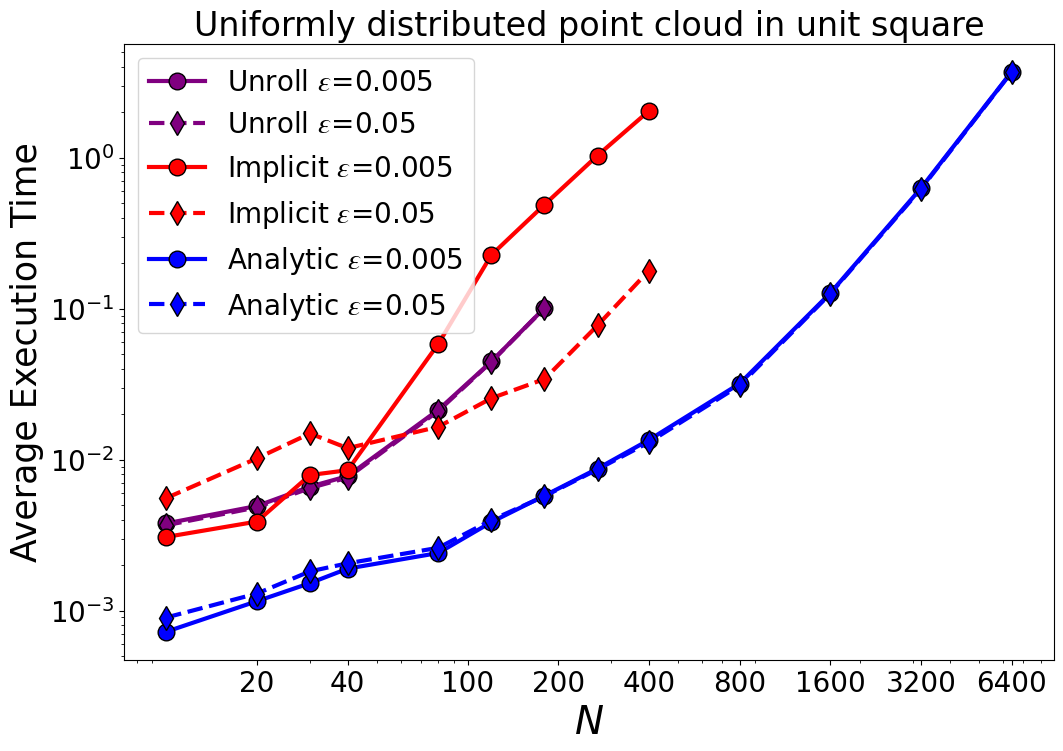

In [6]:
import matplotlib

font = {'size'   : 20}

matplotlib.rc('font', **font)
list_legend = []
fig, ax = plt.subplots(figsize=(12, 8))

n_span       = [10, 20, 30, 40, 80, 120, 180]

ax.plot(n_span, np.nanmean(result_t_unroll[:len(n_span),0,:],axis=1),marker = "o", color="purple",  markersize=12, linestyle="-",
        markeredgecolor="k",
        lw=3,label="Unroll $𝜀$=0.005" )
ax.plot(n_span, np.nanmean(result_t_unroll[:len(n_span),1,:],axis=1),marker = "d", color="purple",  markersize=12, linestyle="--",
        markeredgecolor="k",
        lw=3,label="Unroll $𝜀$=0.05" )


n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400]

ax.plot(n_span, np.nanmean(result_t_implicit[:len(n_span),0,:],axis=1),marker = "o", color="red",  markersize=12, linestyle="-",
        markeredgecolor="k",
        lw=3,label="Implicit $𝜀$=0.005" )
ax.plot(n_span, np.nanmean(result_t_implicit[:len(n_span),1,:],axis=1),marker = "d", color="red",  markersize=12, linestyle="--",
        markeredgecolor="k",
        lw=3,label="Implicit $𝜀$=0.05" )





n_span       = [10, 20, 30, 40, 80, 120, 180, 270, 400, 800, 1600, 3200,6400]
ax.plot(n_span, np.nanmean(result_t_analytic[:len(n_span),0,:],axis=1),marker = "o", color="blue",  markersize=12,linestyle="-",
        markeredgecolor="k",
        lw=3,label="Analytic $𝜀$=0.005" )
ax.plot(n_span, np.nanmean(result_t_analytic[:len(n_span),1,:],axis=1),marker = "d", color="blue",  markersize=12,linestyle="--",
        markeredgecolor="k",
        lw=3,label="Analytic $𝜀$=0.05" )






ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("$N$", fontsize = 28)
#plt.xticks(ticks=np.arange(len(n_span)), labels=n_span)
ax.set_xticks([20, 40, 100, 200, 400, 800, 1600, 3200,6400])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel("Average Execution Time", fontsize = 25)
plt.title("Uniformly distributed point cloud in unit square")
ax.legend()
plt.savefig("speed_uniform.pdf", format="pdf", bbox_inches="tight")
plt.show()
